In [203]:
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [204]:
folders='nonoptimz'

In [205]:
# Utility Functions
def text_preprocessing(text):
    # Lowercase all sentences
    text = text.lower()
    
    # Remove numbers, URLs, email addresses, and punctuation
    text = re.sub(r'[-+]?[0-9]+', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S*@\S*\s?', ' ', text)
    text = re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', text)

    # Correct duplication of characters and remove extra whitespaces
    text = re.sub(r'([a-zA-Z])\1\1+', r'\1', text)
    text = re.sub(r' +', ' ', text).strip()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Tokenize and remove stopwords
    word_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    clean_words = [word for word in word_tokens if word not in stop_words]
    
    return ' '.join(clean_words)


In [206]:

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

def preprocess_and_lemmatize(data_column):
    return data_column.apply(text_preprocessing).apply(lemmatize_text)


In [207]:

def train_and_evaluate_model(model, X_train_split, X_test_split, y_train_split, y_test_split, model_name, test_size, ax):
    # Train the model
    model.fit(X_train_split, y_train_split)
    
    # Make predictions
    predictions = model.predict(X_test_split)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test_split, predictions)
    precision = precision_score(y_test_split, predictions, average='weighted')
    recall = recall_score(y_test_split, predictions, average='weighted')
    f1 = f1_score(y_test_split, predictions, average='weighted')
    conf_matrix = confusion_matrix(y_test_split, predictions)
    
    # Log and plot results
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name} (Test Size {test_size})')
    
    return {
        'Model': model_name,
        'Test Size': test_size,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }


In [208]:

# def load_and_predict(model_name, test_size, X_test, test_data):
#     # Load trained model and make predictions
#     loaded_model = joblib.load(ffolders+'/{model_name}_model_test_size_{test_size}.pkl')
#     predictions = loaded_model.predict(X_test)
#     test_data[f'{model_name}_Prediction_test_size_{test_size}'] = predictions
    
#     # Count class predictions
#     prediction_counts = test_data[f'{model_name}_Prediction_test_size_{test_size}'].value_counts()
#     non_spam_count = prediction_counts.get(0, 0)
#     spam_count = prediction_counts.get(1, 0)
#     total_count = non_spam_count + spam_count
    
#     return {
#         'Model': model_name,
#         'Test Size': test_size,
#         'Non-Spam Count': non_spam_count,
#         'Spam Count': spam_count,
#         'Total Count': total_count
#     }


Training Data Size: 1956
Training Data Distribution:
CLASS
1    1005
0     951
Name: count, dtype: int64


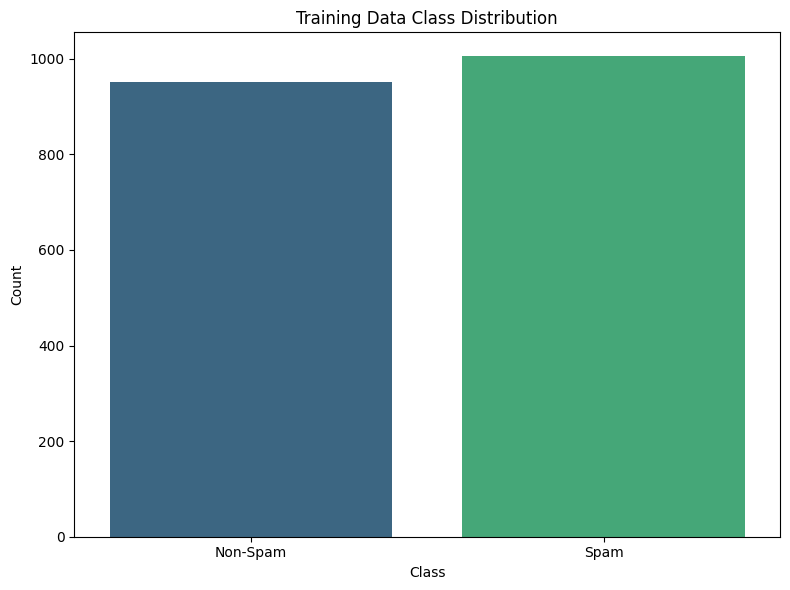

In [209]:

# Load your training dataset
file_path = '../dataset/youtube_spam.csv'
train_data = pd.read_csv(file_path)
train_texts = train_data['CONTENT']
train_labels = train_data['CLASS']

# Display training data size and distribution
print(f'Training Data Size: {len(train_data)}')
print('Training Data Distribution:')
print(train_labels.value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=train_labels, hue=train_labels, palette='viridis', legend=False)
plt.title('Training Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Spam', 'Spam'])
plt.tight_layout()
plt.savefig('training_data_class_distribution.png')
plt.show()



In [210]:

# Apply preprocessing to the training dataset
train_texts = preprocess_and_lemmatize(train_data['CONTENT'])

# Convert the text data into TF-IDF feature vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_texts)

# Define models for training, including SVM with different kernels
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2),
    'NaiveBayes': MultinomialNB(alpha=0.5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=6, learning_rate=0.1),
    'SVM_Linear': SVC(kernel='linear', probability=True, C=1),
    'SVM_RBF': SVC(kernel='rbf', probability=True, C=1, gamma='scale'),
    'SVM_Poly': SVC(kernel='poly', probability=True, C=1, degree=3),
    'SVM_Sigmoid': SVC(kernel='sigmoid', probability=True, C=1)
}



Evaluating with test size: 0.2

Training and Evaluating RandomForest with test size 0.2...
Accuracy: 0.87
Precision: 0.89
Recall: 0.87
F1 Score: 0.87
Confusion Matrix:
[[172   4]
 [ 47 169]]

Training and Evaluating NaiveBayes with test size 0.2...
Accuracy: 0.87
Precision: 0.88
Recall: 0.87
F1 Score: 0.87
Confusion Matrix:
[[158  18]
 [ 32 184]]

Training and Evaluating XGBoost with test size 0.2...
Accuracy: 0.90
Precision: 0.91
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[170   6]
 [ 35 181]]

Training and Evaluating SVM_Linear with test size 0.2...
Accuracy: 0.90
Precision: 0.91
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[168   8]
 [ 31 185]]

Training and Evaluating SVM_RBF with test size 0.2...
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[167   9]
 [ 32 184]]

Training and Evaluating SVM_Poly with test size 0.2...
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[152  24]
 [ 17 199]]

Training and Evaluating S

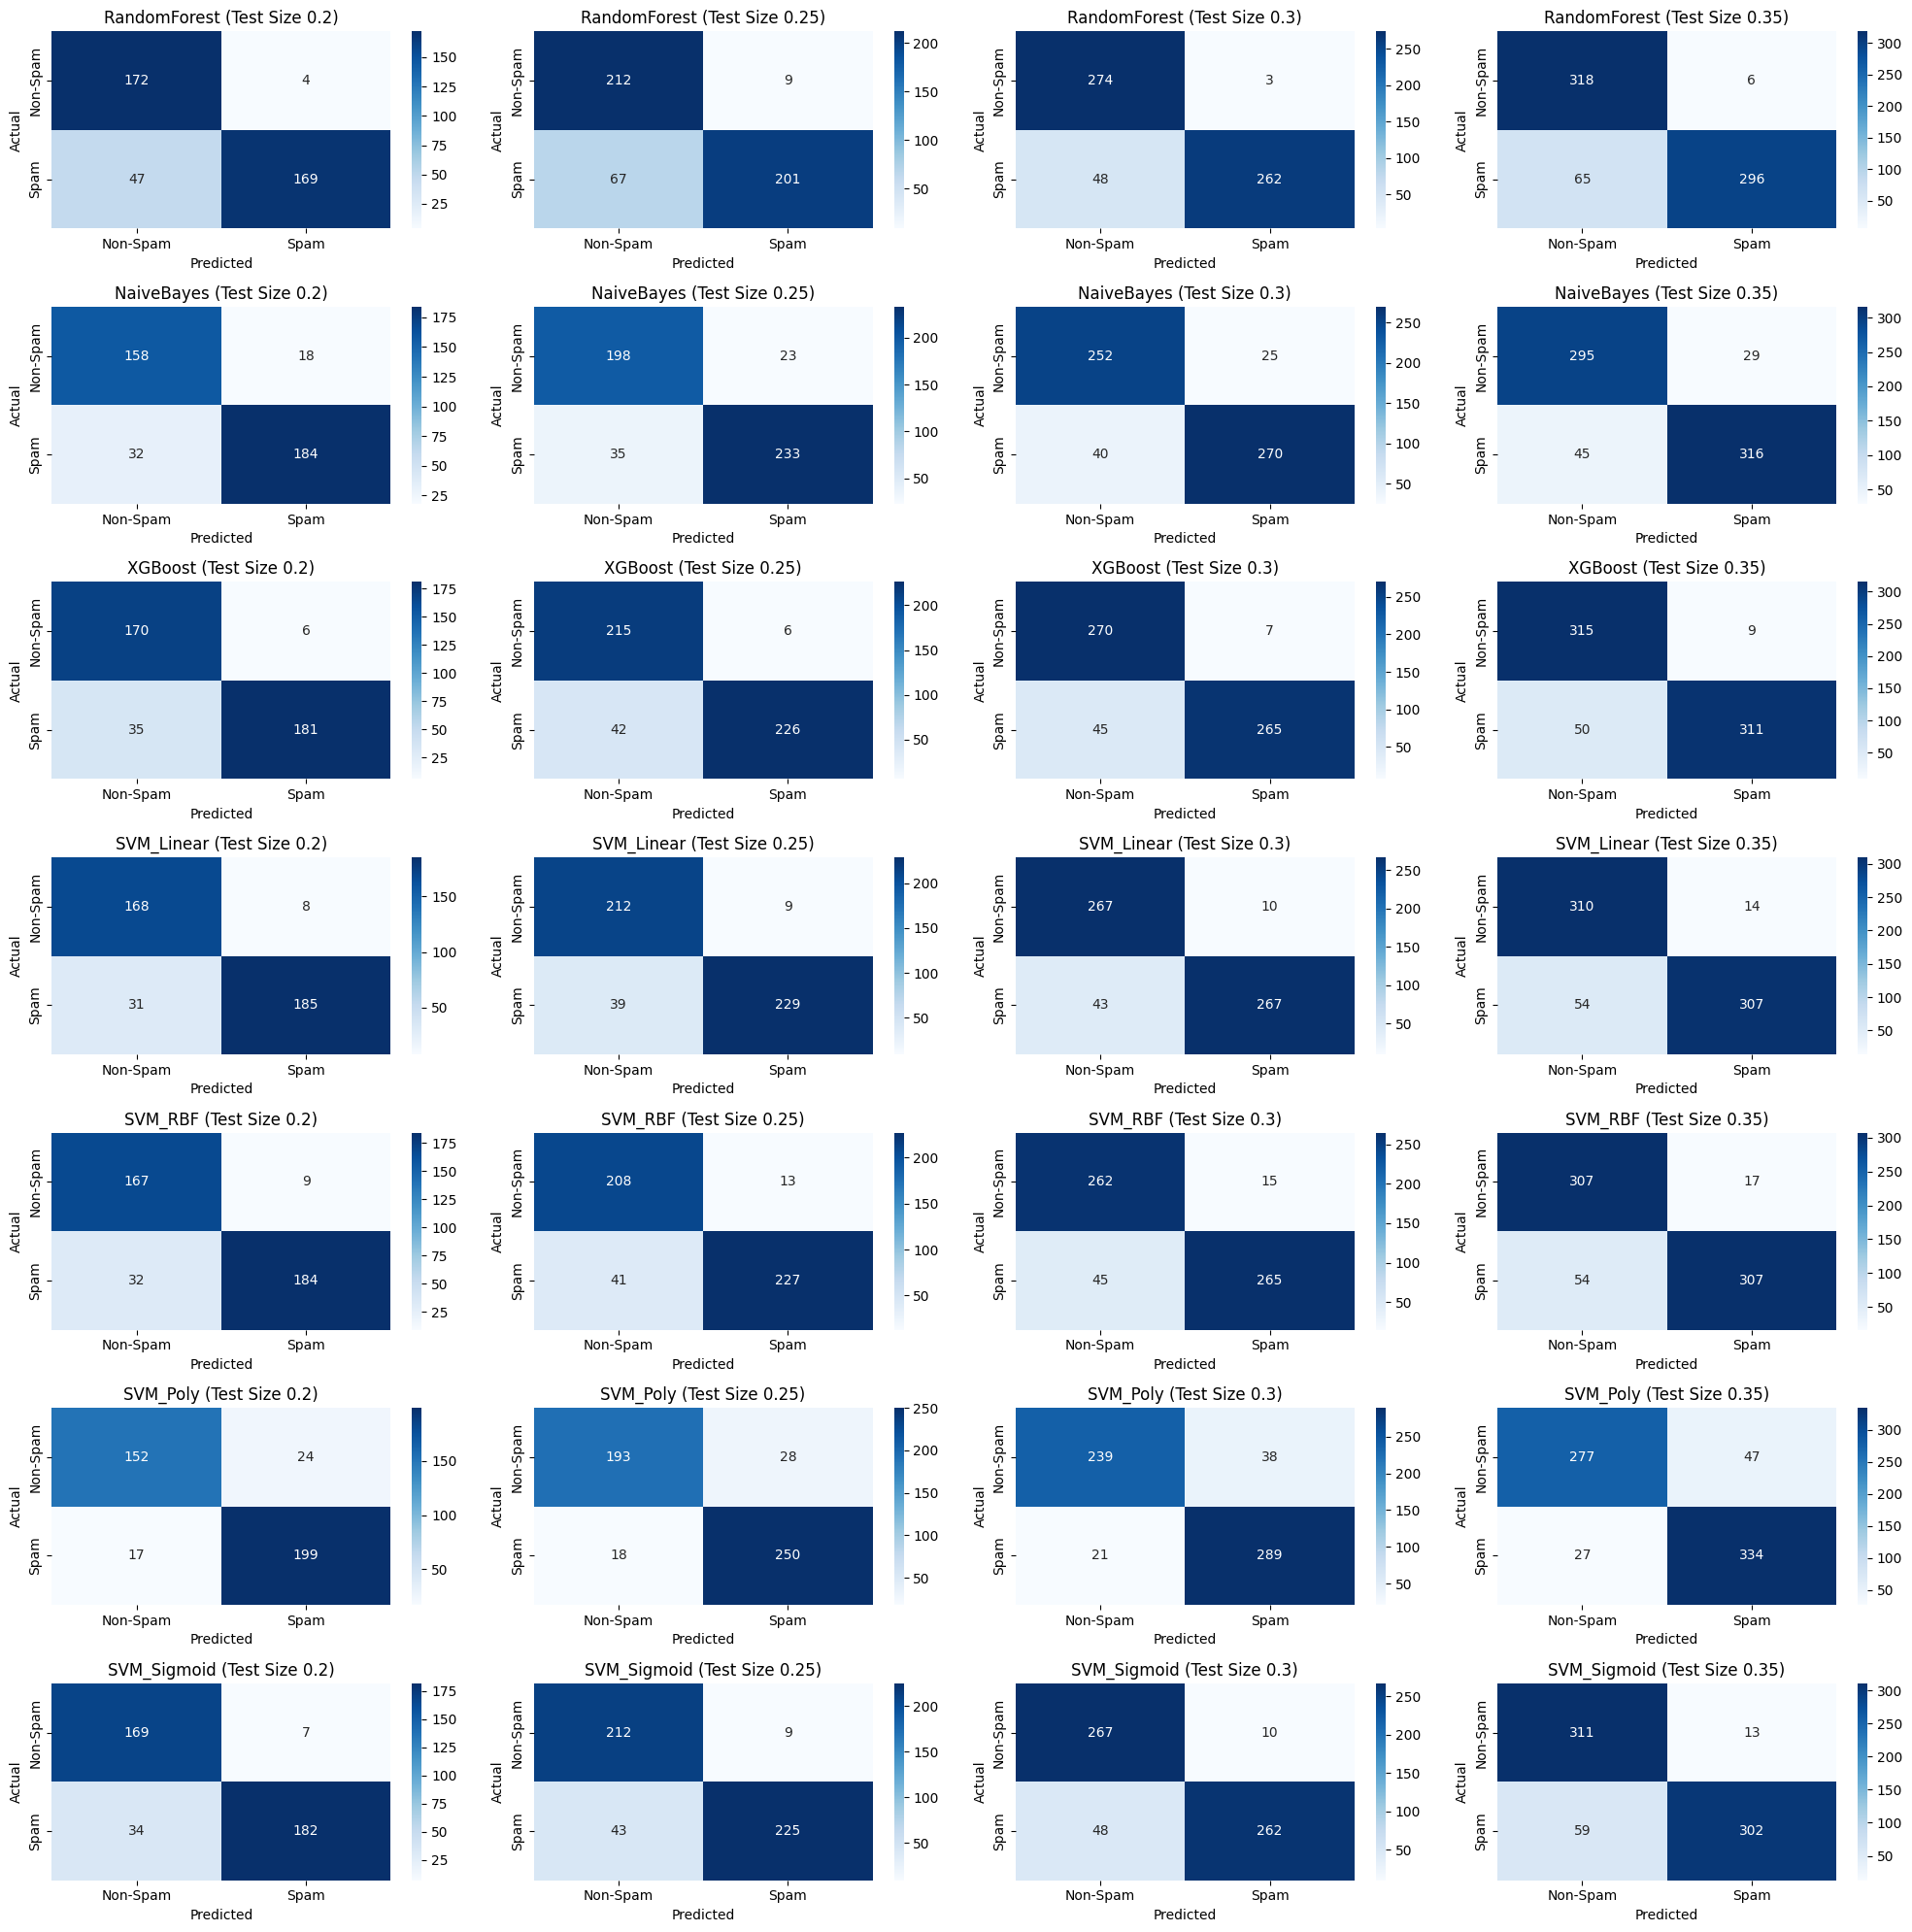

Model evaluation results saved to model_evaluation_results.csv


In [211]:
# Train and evaluate each model with different test sizes
test_sizes = [0.2, 0.25, 0.3, 0.35]
fig, axes = plt.subplots(len(models), len(test_sizes), figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

results = []
for test_size_idx, test_size in enumerate(test_sizes):
    print(f'\nEvaluating with test size: {test_size}')
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, train_labels, test_size=test_size, random_state=42)
    
    for model_idx, (model_name, model) in enumerate(models.items()):
        print(f'\nTraining and Evaluating {model_name} with test size {test_size}...')
        results.append(train_and_evaluate_model(model, X_train_split, X_test_split, y_train_split, y_test_split, model_name, test_size, axes[model_idx, test_size_idx]))
        # Save the trained model
        joblib.dump(model, f'nonoptimz/{model_name}_model_test_size_{test_size}.pkl')

plt.tight_layout()
plt.savefig('nonoptimz/combined_confusion_matrix_plot.png')
plt.show()

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Save evaluation results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('nonoptimz/model_evaluation_results.csv', index=False)
print('Model evaluation results saved to model_evaluation_results.csv')

In [212]:
y_test_split

1360    0
1703    0
1146    1
1758    1
374     1
       ..
746     0
589     1
1525    0
18      1
423     0
Name: CLASS, Length: 685, dtype: int64

In [213]:
# Load and preprocess the testing dataset
test_data_path = '../dataset/youtube_comments_i6IOiUi6IYY.xlsx'
test_data = pd.read_excel(test_data_path)
test_texts = preprocess_and_lemmatize(test_data['Comment'])

# Add cleaned comments to the original dataset
test_data['cleaned_comment'] = test_texts

# Save dataset with cleaned comments to CSV
test_data.to_csv('nonoptimz/youtube_comments_with_cleaned.csv', index=False)
print('Dataset with cleaned comments saved to youtube_comments_with_cleaned.csv')

Dataset with cleaned comments saved to youtube_comments_with_cleaned.csv


In [214]:
# def load_and_predict(model_name, test_size, X_test, y_test, test_data):
#     # Load trained model and make predictions
#     loaded_model = joblib.load(f'{model_name}_model_test_size_{test_size}.pkl')
#     predictions = loaded_model.predict(X_test)
#     test_data[f'{model_name}_Prediction_test_size_{test_size}'] = predictions
    
#     # Evaluate predictions with confusion matrix
#     conf_matrix = confusion_matrix(y_test, predictions)
#     accuracy = accuracy_score(y_test, predictions)
#     precision = precision_score(y_test, predictions, average='weighted')
#     recall = recall_score(y_test, predictions, average='weighted')
#     f1 = f1_score(y_test, predictions, average='weighted')

#     # Count class predictions
#     prediction_counts = test_data[f'{model_name}_Prediction_test_size_{test_size}'].value_counts()
#     non_spam_count = prediction_counts.get(0, 0)
#     spam_count = prediction_counts.get(1, 0)
#     total_count = non_spam_count + spam_count
    
#     # Log results
#     print(f'\nTest Evaluation for {model_name} with test size {test_size}:')
#     print(f'Accuracy: {accuracy:.2f}')
#     print(f'Precision: {precision:.2f}')
#     print(f'Recall: {recall:.2f}')
#     print(f'F1 Score: {f1:.2f}')
#     print(f'Confusion Matrix:\n{conf_matrix}')
    
#     return {
#         'Model': model_name,
#         'Test Size': test_size,
#         'Non-Spam Count': non_spam_count,
#         'Spam Count': spam_count,
#         'Total Count': total_count,
#         'Accuracy': accuracy,
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': f1,
#         'Confusion Matrix': conf_matrix
#     }
# def load_and_predict(model_name, test_size, X_test, y_test_split, test_data):
#     # Load trained model and make predictions
#     loaded_model = joblib.load(f'{model_name}_model_test_size_{test_size}.pkl')
#     predictions = loaded_model.predict(X_test)
#     test_data[f'{model_name}_Prediction_test_size_{test_size}'] = predictions
    
#     # Evaluate predictions
#     prediction_counts = test_data[f'{model_name}_Prediction_test_size_{test_size}'].value_counts()
#     non_spam_count = prediction_counts.get(0, 0)
#     spam_count = prediction_counts.get(1, 0)
#     total_count = non_spam_count + spam_count

#     # Evaluate predictions
#     accuracy = accuracy_score(y_test_split, predictions)
#     precision = precision_score(y_test_split, predictions, average='weighted')
#     recall = recall_score(y_test_split, predictions, average='weighted')
#     f1 = f1_score(y_test_split, predictions, average='weighted')
#     conf_matrix = confusion_matrix(y_test_split, predictions)
    
#     # Log results
#     print(f'Test Evaluation for {model_name} with test size {test_size}:')
#     print(f'Non-Spam Count: {non_spam_count}')
#     print(f'Spam Count: {spam_count}')
#      # Log results
#     # print(f'\nTest Evaluation for {model_name} with test size {test_size}:')
#     print(f'Accuracy: {accuracy:.2f}')
#     print(f'Precision: {precision:.2f}')
#     print(f'Recall: {recall:.2f}')
#     print(f'F1 Score: {f1:.2f}')
#     print(f'Confusion Matrix:\n{conf_matrix}')
    
#     return {
#         'Model': model_name,
#         'Test Size': test_size,
#         'Non-Spam Count': non_spam_count,
#         'Spam Count': spam_count,
#         'Total Count': total_count,
#         # 'Model': model_name,
#         # 'Test Size': test_size,
#         'Accuracy': accuracy,
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': f1,
#         'Confusion Matrix': conf_matrix
#     }


In [215]:
# Load the TF-IDF vectorizer and transform the test data
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')
X_test = loaded_vectorizer.transform(test_texts)

# Load models and make predictions
test_results = []
for test_size in test_sizes:
    for model_name in models.keys():
        print(f'\nLoading {model_name} model trained with test size {test_size} and making predictions...')
        # test_results.append(load_and_predict(model_name, test_size, X_test, y_test_split, test_data))
        # test_results.append(load_and_predict(model_name, test_size, X_test, test_data))
        # Load trained model and make predictions
        # Load trained model and make predictions
        loaded_model = joblib.load(f'nonoptimz/{model_name}_model_test_size_{test_size}.pkl')
        predictions = loaded_model.predict(X_test)
        test_data[f'{model_name}_Prediction_test_size_{test_size}'] = predictions
        
        # Ensure the lengths of y_test_split and predictions match before evaluation
        min_length = min(len(y_test_split), len(predictions))
        y_test_split = y_test_split[:min_length]
        predictions = predictions[:min_length]
        
        # Evaluate predictions
        accuracy = accuracy_score(y_test_split, predictions)
        precision = precision_score(y_test_split, predictions, average='weighted')
        recall = recall_score(y_test_split, predictions, average='weighted')
        f1 = f1_score(y_test_split, predictions, average='weighted')
        conf_matrix = confusion_matrix(y_test_split, predictions)
        
        # Log results
        print(f'\nTest Evaluation for {model_name} with test size {test_size}:')
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1:.2f}')
        print(f'Confusion Matrix:\n{conf_matrix}')
        
        test_results.append({
            'Model': model_name,
            'Test Size': test_size,
            'Non-Spam Count': (predictions == 0).sum(),
            'Spam Count': (predictions == 1).sum(),
            'Total Count': len(predictions),
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            # 'Confusion Matrix': conf_matrix
        })
        



Loading RandomForest model trained with test size 0.2 and making predictions...

Test Evaluation for RandomForest with test size 0.2:
Accuracy: 0.48
Precision: 0.52
Recall: 0.48
F1 Score: 0.32
Confusion Matrix:
[[308   4]
 [336   5]]

Loading NaiveBayes model trained with test size 0.2 and making predictions...

Test Evaluation for NaiveBayes with test size 0.2:
Accuracy: 0.54
Precision: 0.54
Recall: 0.54
F1 Score: 0.53
Confusion Matrix:
[[120 192]
 [106 235]]

Loading XGBoost model trained with test size 0.2 and making predictions...

Test Evaluation for XGBoost with test size 0.2:
Accuracy: 0.48
Precision: 0.47
Recall: 0.48
F1 Score: 0.32
Confusion Matrix:
[[305   7]
 [335   6]]

Loading SVM_Linear model trained with test size 0.2 and making predictions...

Test Evaluation for SVM_Linear with test size 0.2:
Accuracy: 0.52
Precision: 0.55
Recall: 0.52
F1 Score: 0.47
Confusion Matrix:
[[259  53]
 [263  78]]

Loading SVM_RBF model trained with test size 0.2 and making predictions...

T

Predictions saved to youtube_comments_predictions.xlsx and youtube_comments_predictions.csv
Test evaluation results saved to test_evaluation_results.csv


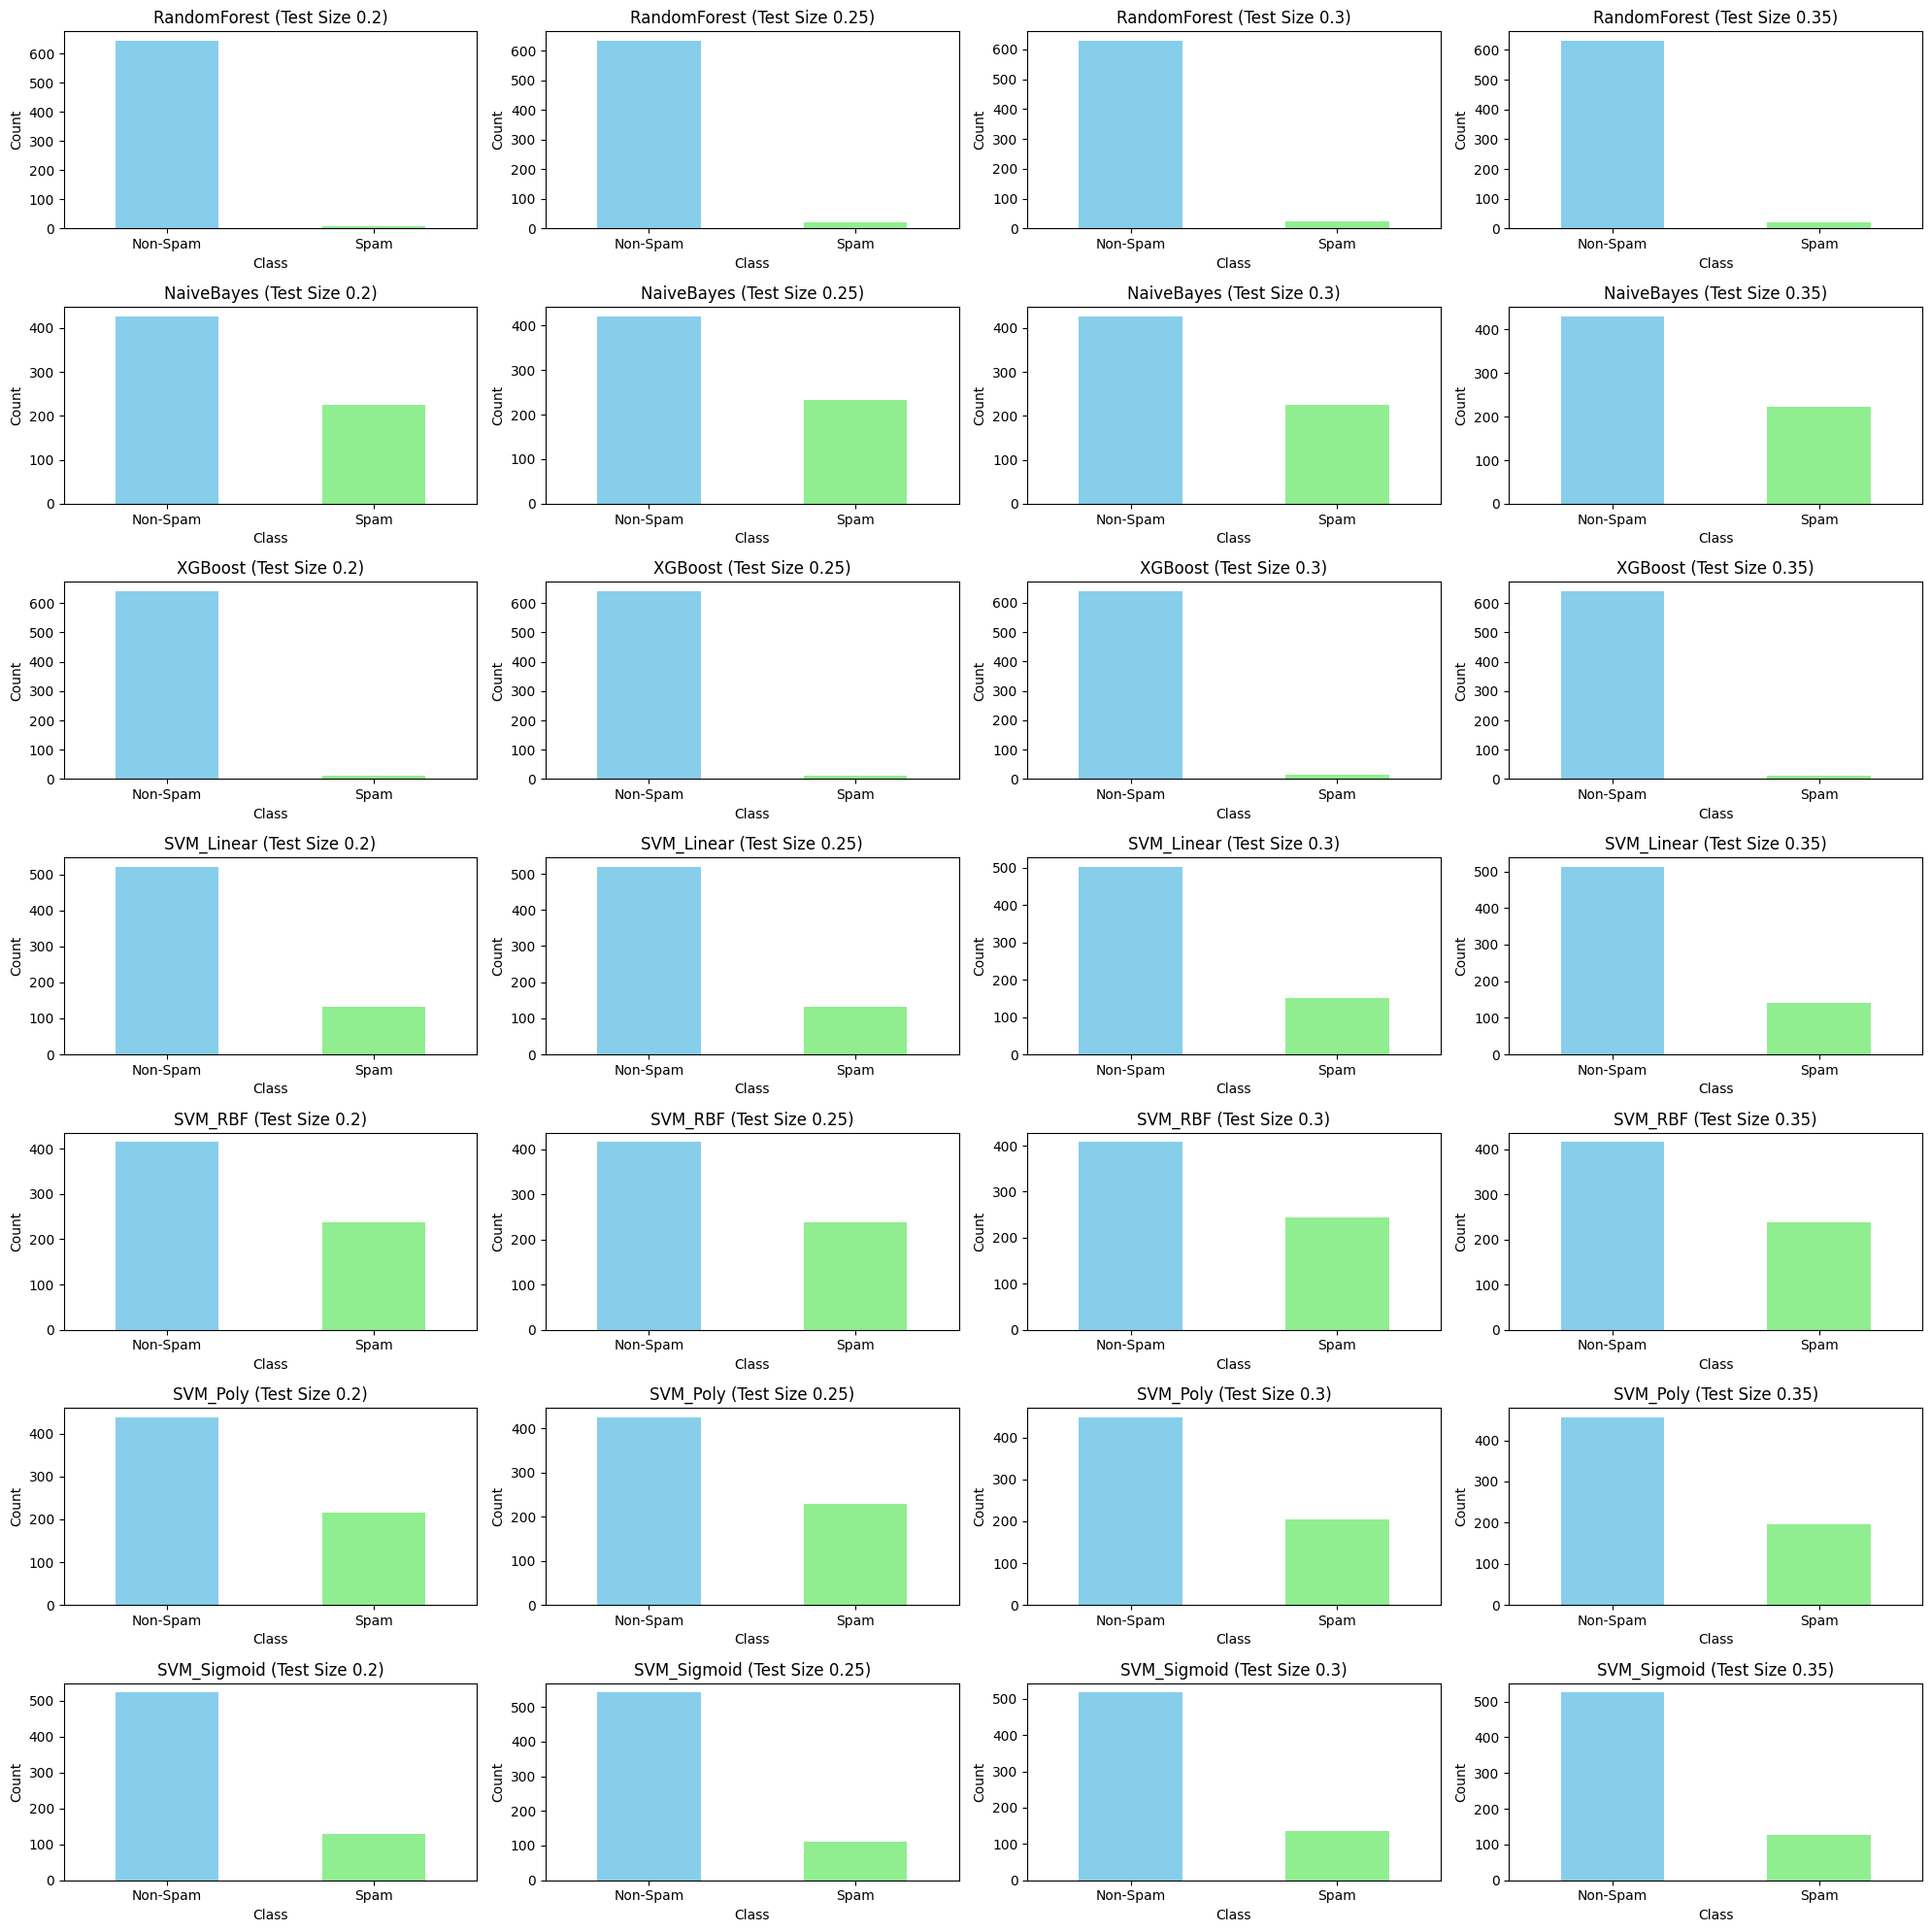

In [217]:
# Save the predictions to an Excel file and CSV file
test_data.to_excel('nonoptimz/youtube_comments_predictions.xlsx', index=False)
test_data.to_csv('nonoptimz/youtube_comments_predictions.csv', index=False)
print('Predictions saved to youtube_comments_predictions.xlsx and youtube_comments_predictions.csv')

# Save test evaluation results to CSV
test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv('nonoptimz/test_evaluation_results.csv', index=False)
test_results_df.to_excel('nonoptimz/test_evaluation_results.xlsx', index=False)
print('Test evaluation results saved to test_evaluation_results.csv')

# Visualize the distribution of predictions for each model and test size
fig, axes = plt.subplots(len(models), len(test_sizes), figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for test_size_idx, test_size in enumerate(test_sizes):
    for model_idx, model_name in enumerate(models.keys()):
        ax = axes[model_idx, test_size_idx]
        test_data[f'{model_name}_Prediction_test_size_{test_size}'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'], ax=ax)
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')
        ax.set_title(f'{model_name} (Test Size {test_size})')
        ax.set_xticklabels(['Non-Spam', 'Spam'], rotation=0)

plt.tight_layout()
plt.savefig('nonoptimz/combined_predictions_distribution.png')
plt.show()